In [113]:
import os
import sys

sys.path.append(os.path.dirname(os.getcwd()))

import pandas as pd
import glob
import matplotlib.pyplot as plt

from utils.conn_data import load_pickle

plt.style.use('ggplot')

In [4]:
outputs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "outputs")
des = pd.read_csv(os.path.join(os.path.dirname(os.getcwd()), 'data', 'utils', 'fredmd_description.csv'), sep=';')

fs_methods = ["lasso", "multivariate-granger", "pairwise-granger", "var-lingam"]
metric_names = ["stability", "mse", "mae"]
etf_focus = None
stability_threshold = 0.8
plot_ts = False

In [134]:
all_parents = []
for fs in fs_methods:
    results_files = glob.glob(os.path.join(outputs_path, fs, "etfs_macro_large", "*.pickle"))

    for file in results_files:
        etf = file.split(fs)[-1].split("/")[-1].split("_")[0]
        obj = load_pickle(path=file)
        parents_of_target_df = obj["parents_of_target"]

        parents_of_target_df["etf"] = etf
        parents_of_target_df["fs"] = fs

        all_parents.append(parents_of_target_df)
all_parents_df = pd.concat(all_parents)

In [161]:
etf_df = all_parents_df[(all_parents_df["etf"] == "SPY")]

sets_over_time = []
for date in etf_df["date"].unique():
    s = set(list(etf_df["cluster"].dropna().unique()))
    tmp_df = pd.DataFrame([{"date": date, "tot": s}])

    sets_over_time.append(tmp_df)
tot_df = pd.concat(sets_over_time)

individual = []
for fs in etf_df["fs"].unique():
    fs_etf_df = etf_df[etf_df["fs"] == fs]

    sets_over_time = []
    for date in fs_etf_df["date"].unique():
        s = set(list(fs_etf_df[fs_etf_df["date"] == date].dropna()["cluster"].unique()))
        tmp_set_df = pd.DataFrame([{"date": date, "set": s}])

        sets_over_time.append(tmp_set_df)
    tmp_individual_df = pd.concat(sets_over_time)
    tmp_individual_df["fs"] = fs
    
    individual.append(tmp_individual_df)
individual_df = pd.concat(individual).reset_index(drop=True)

individual_tot_df = pd.merge(individual_df, tot_df, on="date")[["date", "fs", "set", "tot"]].reset_index(drop=True)
for idx, row in individual_tot_df.iterrows():
    stability = len(row["set"].intersection(row["tot"])) / len(row["tot"]) 
    individual_tot_df.loc[idx, "stability"] = stability

<Axes: xlabel='date'>

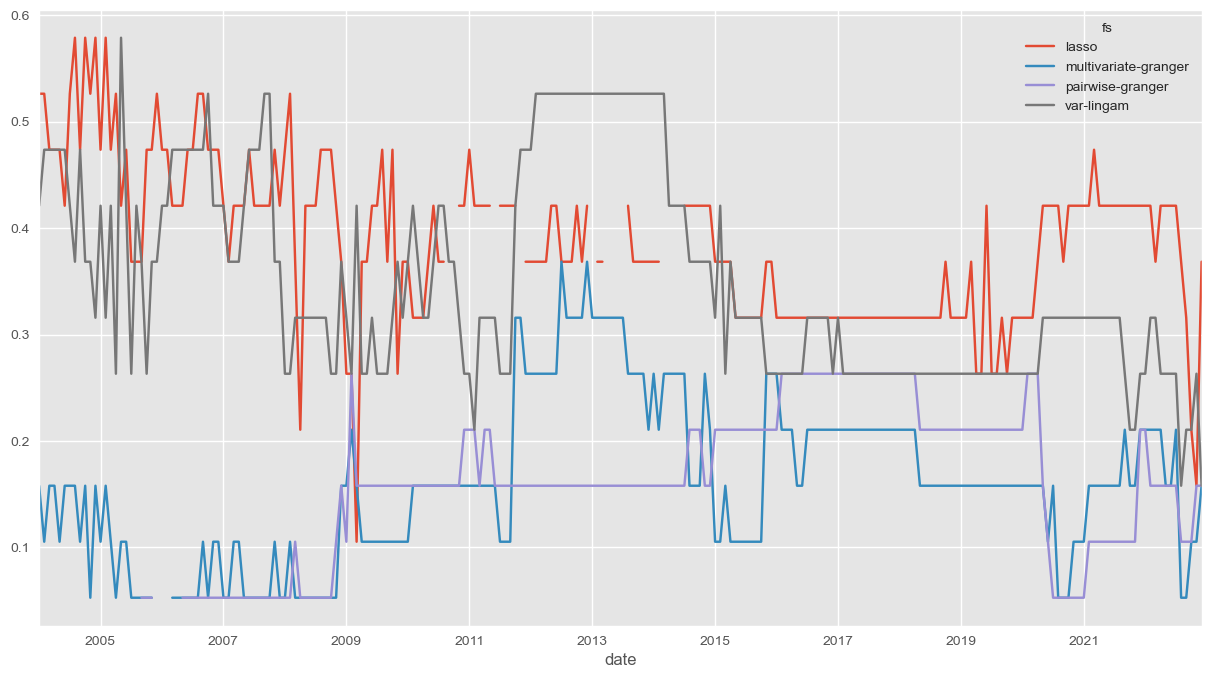

In [165]:
individual_tot_df.pivot_table(index="date", columns="fs", values="stability").plot(figsize=(15, 8))